In [1]:
import pandas as pd
data = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/train.csv", sep=',')
data['Id'] = data['Id'] + '.jpg'
data = data.rename(columns={'Id': 'filename'})
data = data.drop(columns=['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'])
data

,filename,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0.jpg,63
1,0009c66b9439883ba2750fb825e1d7db.jpg,42
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,28
3,0018df346ac9c1d8413cfcc888ca8246.jpg,15
4,001dc955e10590d3ca4673f034feeef2.jpg,72
...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57.jpg,15
9908,ffcc8532d76436fc79e50eb2e5238e45.jpg,70
9909,ffdf2e8673a1da6fb80342fa3b119a20.jpg,20
9910,fff19e2ce11718548fa1c5d039a5192a.jpg,20


On copie les fichiers du dataset dans une arbo de type classification

In [2]:
dataset_dir = '/kaggle/input/petfinder-pawpularity-score/train'
width, height = 512, 512
batch_size = 32
nb_classes = 5

import os
path = "/kaggle/working/data"
if not os.path.exists(path):
    os.mkdir(path)

from shutil import copyfile
for i in range(nb_classes):
    mini = i * int(100 / nb_classes)
    maxi = (i + 1) * int(100 / nb_classes)
    class_data = data[(data['Pawpularity'] > mini) & (data['Pawpularity'] <= maxi)]
    class_dir = os.path.join(path, str(mini) + '-' + str(maxi))
    os.mkdir(class_dir)
    for filename in class_data['filename']:
        src = os.path.join(dataset_dir, filename)
        dst = os.path.join(class_dir, filename)
        copyfile(src, dst)

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
train_ds = image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_ds = image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)

Found 9912 files belonging to 5 classes.
Using 7930 files for training.


2021-12-24 11:46:42.968345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 11:46:43.063161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 11:46:43.063830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 11:46:43.066671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 9912 files belonging to 5 classes.
Using 1982 files for validation.


In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_callback = EarlyStopping(
    monitor="accuracy",
    min_delta=1,  # sous les 1% de mieux, on patiente
    patience=10,  # on patiente max 10 epochs
    verbose=2,
    mode="min",
    restore_best_weights=True
)
model_checkpoint_callback = ModelCheckpoint(
    'efficientNet_reg.h5',
    monitor="accuracy",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch"
)
callbacks = [early_stopping_callback, model_checkpoint_callback]

In [5]:
import sys
import os
sys.path.insert(0, "/kaggle/input/efnetv2src/efficientnet-v2-keras-main")
sys.path.append('../input/tfkeras-efficientnetsv2/')
from efficientnet_v2 import EfficientNetV2XL

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
data_augmentation = Sequential([
  RandomFlip("horizontal", input_shape=(height, width, 3)),
  RandomRotation(factor=0.4, fill_mode="wrap"),
  RandomZoom(0.2),
  RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
  RandomContrast(factor=0.2)
])

In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow_addons as tfa

efficientnet = EfficientNetV2XL(
    include_top=False,
    weights='../input/tfkeras-efficientnetsv2/21_ft1k_notop/efficientnetv2-xl-21k-ft1k_notop.h5', 
    input_shape=(height, width, 3),
    classes=nb_classes
)
efficientnet.trainable = False

inputs = Input(shape=(height, width, 3))
x = data_augmentation(inputs)
x = efficientnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
class1 = Dense(1920, activation='relu')(x)
outputs = Dense(nb_classes, activation='softmax')(class1)
efficientnet = Model(inputs, outputs)

radam = tfa.optimizers.RectifiedAdam(learning_rate=0.01)
optimizer = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

efficientnet.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [8]:
epochs = 100
history_efficientnet = efficientnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100


2021-12-24 11:47:19.015356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-24 11:47:35.755880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


248/248 [==============================] - 477s 2s/step - loss: 1.9677 - accuracy: 0.3961 - val_loss: 1.5647 - val_accuracy: 0.3951


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
248/248 [==============================] - 436s 2s/step - loss: 1.5117 - accuracy: 0.4401 - val_loss: 1.4606 - val_accuracy: 0.4945
Epoch 3/100
248/248 [==============================] - 437s 2s/step - loss: 1.4189 - accuracy: 0.4767 - val_loss: 1.4363 - val_accuracy: 0.5106
Epoch 4/100
248/248 [==============================] - 437s 2s/step - loss: 1.3721 - accuracy: 0.5008 - val_loss: 1.3711 - val_accuracy: 0.5197
Epoch 5/100
248/248 [==============================] - 438s 2s/step - loss: 1.3548 - accuracy: 0.5045 - val_loss: 1.3322 - val_accuracy: 0.5217
Epoch 6/100
248/248 [==============================] - 437s 2s/step - loss: 1.3389 - accuracy: 0.5115 - val_loss: 1.3229 - val_accuracy: 0.5126
Epoch 7/100
248/248 [==============================] - 438s 2s/step - loss: 1.3265 - accuracy: 0.5122 - val_loss: 1.3199 - val_accuracy: 0.5197
Epoch 8/100
248/248 [==============================] - 438s 2s/step - loss: 1.3168 - accuracy: 0.5132 - val_loss: 1.4061 - val_accuracy:

In [9]:
history_efficientnet.history

{'loss': [1.9677069187164307,
  1.5116671323776245,
  1.4188792705535889,
  1.3721328973770142,
  1.354760766029358,
  1.3388954401016235,
  1.326451301574707,
  1.3167507648468018,
  1.3137227296829224,
  1.3086063861846924,
  1.3065433502197266],
 'accuracy': [0.3960908055305481,
  0.44010087847709656,
  0.47667086124420166,
  0.5007566213607788,
  0.5045397281646729,
  0.5114753842353821,
  0.5122320055961609,
  0.5132408738136292,
  0.5133669376373291,
  0.5143758058547974,
  0.5143758058547974],
 'val_loss': [1.5647315979003906,
  1.4605754613876343,
  1.436259150505066,
  1.3710553646087646,
  1.3322033882141113,
  1.3228809833526611,
  1.3199291229248047,
  1.4061362743377686,
  1.2965447902679443,
  1.2950139045715332,
  1.2980897426605225],
 'val_accuracy': [0.39505550265312195,
  0.49445006251335144,
  0.5105953812599182,
  0.5196771025657654,
  0.5216952562332153,
  0.5126135349273682,
  0.5196771025657654,
  0.5216952562332153,
  0.5216952562332153,
  0.5216952562332153,
  

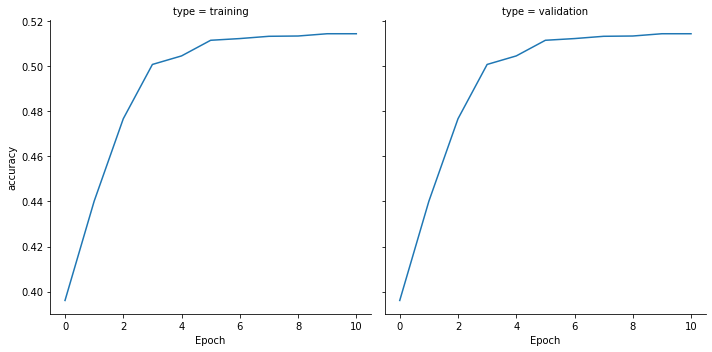

In [10]:
import matplotlib.pyplot as plt

dict1 = {
    "accuracy": history_efficientnet.history["accuracy"],
    "type": "training"
}
dict2 = {
    "accuracy": history_efficientnet.history["accuracy"],
    "type": "validation"
}
s1 = pd.DataFrame(dict1)
s2 = pd.DataFrame(dict2)
df = pd.concat([s1, s2], axis=0).reset_index()
import seaborn as sns
grid = sns.relplot(
    data=df,
    x=df["index"],
    y="accuracy",
    col="type",
    kind="line"
)
for ax in grid.axes.flat:
    ax.set(xlabel="Epoch")
plt.show()

In [11]:
import tensorflow as tf
def preprocess(image):
    return (tf.cast(image, dtype=tf.float32) - 128.00) / 128.00

In [12]:
train_ds.class_names

['0-20', '20-40', '40-60', '60-80', '80-100']

In [13]:
import os
import numpy as np
from PIL import Image
test_dir = '/kaggle/input/petfinder-pawpularity-score/test'
ids = []
pawpularities = []
for test_image in os.listdir(test_dir):
    image_path = os.path.join(test_dir, test_image)
    id_image = test_image.split('.')[0]
    ids.append(id_image)
    img = Image.open(image_path) 
    img = img.resize((width, height))
    img = preprocess(np.array(img).reshape(1, width, height, 3))
    preds = efficientnet.predict(img)
    top_indice = preds[0].argsort()[-1]
    result = train_ds.class_names[top_indice]
    pawpularities.append(result)

In [14]:
data = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/train.csv", sep=',')
X = data.drop(columns=['Id', 'Pawpularity'])
y = data['Pawpularity']
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=1)
from catboost import CatBoostRegressor
import time
start = time.time()

cb = CatBoostRegressor(depth=5,
                       learning_rate=0.01,
                       n_estimators=50,
                       loss_function='RMSE',
                       task_type='CPU',
                       verbose=False)

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)

import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

cb_rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE for CatBoost: ", np.mean(cb_rmse))

end = time.time()
diff = end - start
print('Execution time for CatBoost (in Seconds):', diff)

print("r2_score : {:.2f}".format(r2_score(y_test, y_pred)))

RMSE for CatBoost:  20.470036456990314
Execution time for CatBoost (in Seconds): 0.16500210762023926
r2_score : -0.00


In [15]:
sub_df = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/test.csv", sep=',')
X_sub = sub_df.drop(columns=['Id'])

test_dir = '/kaggle/input/petfinder-pawpularity-score/test'
ids = []
pawpularities = []
for test_image in os.listdir(test_dir):
    image_path = os.path.join(test_dir, test_image)
    id_image = test_image.split('.')[0]
    ids.append(id_image)
    img = Image.open(image_path) 
    img = img.resize((width, height))
    img = preprocess(np.array(img).reshape(1, width, height, 3))
    preds = efficientnet.predict(img)
    top_indice = preds[0].argsort()[-1]
    result = train_ds.class_names[top_indice]
    pawpularities.append(result)

img_dict = {
    'Id': ids,
    'Pawpularity': pawpularities
}
img_df = pd.DataFrame(img_dict)
print(img_df)

print("shape X_sub: ", X_sub.shape)
y_sub = cb.predict(X_sub)
y_sub = [round(x) for x in y_sub]
sub_df['Pawpularity'] = y_sub
sub_df = sub_df.drop(columns=['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'])

                                 Id Pawpularity
0  c978013571258ed6d4637f6e8cc9d6a3       20-40
1  4e429cead1848a298432a0acad014c9d       20-40
2  43a2262d7738e3d420d453815151079e       20-40
3  8f49844c382931444e68dffbe20228f4       20-40
4  4128bae22183829d2b5fea10effdb0c3       20-40
5  80bc3ccafcc51b66303c2c263aa38486       20-40
6  e0de453c1bffc20c22b072b34b54e50f       20-40
7  b03f7041962238a7c9d6537e22f9b017       20-40
shape X_sub:  (8, 12)


In [16]:
print(sub_df)
for id_img in sub_df['Id']:
    result = img_df[img_df['Id'] == id_img]['Pawpularity']
    result = result.values[0]
    mini = int(result.split('-')[0])
    maxi = int(result.split('-')[1])
    p = sub_df[sub_df['Id'] == id_img]['Pawpularity'].values[0]
    print(p, mini, maxi)
    if p < mini:
        p = int(round(p + (mini - p) / 4))
    if p > maxi:
        p = int(round(p - (p - maxi) / 4))
    print("=>", p)
    sub_df.at[sub_df['Id'] == id_img, 'Pawpularity'] = p
    
print(sub_df)
sub_df.to_csv('submission.csv', index=False, sep=',')

                                 Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3           39
1  43a2262d7738e3d420d453815151079e           38
2  4e429cead1848a298432a0acad014c9d           38
3  80bc3ccafcc51b66303c2c263aa38486           37
4  8f49844c382931444e68dffbe20228f4           37
5  b03f7041962238a7c9d6537e22f9b017           39
6  c978013571258ed6d4637f6e8cc9d6a3           38
7  e0de453c1bffc20c22b072b34b54e50f           37
39 20 40
=> 39
38 20 40
=> 38
38 20 40
=> 38
37 20 40
=> 37
37 20 40
=> 37
39 20 40
=> 39
38 20 40
=> 38
37 20 40
=> 37
                                 Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3           39
1  43a2262d7738e3d420d453815151079e           38
2  4e429cead1848a298432a0acad014c9d           38
3  80bc3ccafcc51b66303c2c263aa38486           37
4  8f49844c382931444e68dffbe20228f4           37
5  b03f7041962238a7c9d6537e22f9b017           39
6  c978013571258ed6d4637f6e8cc9d6a3           38
7  e0de453c1bffc20c22b072b34b54e50f           3